<a href="https://colab.research.google.com/github/christinevu510/Drug-Classification/blob/main/Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Drug Classification**

Mackenzie Carter, Vannessa Salazar, and Christine Vu

Shiley-Marcos School of Engineering, University of San Diego

ADS 509: Applied Text Mining

Professor Anna Marbut

October 23, 2023

***

## **Data Importing**

### **Import Libraries**

In [ ]:
import requests
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import sklearn.metrics
import json
import pickle
import string
import os
import re
import nltk
import seaborn as sns
import sqlite3
import random

from bs4 import BeautifulSoup
# from pandas.io.json import json_normalize
from collections import Counter, defaultdict
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from nltk.tokenize import word_tokenize
from sklearn.naive_bayes import MultinomialNB
from string import punctuation
from wordcloud import WordCloud

### **Obtain URLs**

In [ ]:
# URLs
anx_URL = "https://api.fda.gov/drug/label.json?search=purpose:'anxiety'&limit=10"
pain_URL = "https://api.fda.gov/drug/label.json?search=purpose:'pain'&limit=10"
dementia_URL = "https://api.fda.gov/drug/label.json?search=purpose:'dementia'&limit=100"

In [ ]:
def fetch_data_from_api(search_conditions, limit = 100, total_limit = 10000):
    api_endpoint = "https://api.fda.gov/drug/label.json"
    all_data = []

    try:
        while len(all_data) < total_limit:
            params = {
                'search': 'purpose:' + '+'.join(search_conditions),
                'limit': limit,
                'skip': len(all_data)  # Use skip to paginate
            }

            response = requests.get(api_endpoint, params=params)
            if response.status_code == 200:
                data = response.json()
                results = data.get("results", [])
                if not results:
                    break  # No more data available, exit the loop
                all_data.extend(results)
            else:
                print(f"Error: {response.status_code}")
                break
    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")

    return all_data

# Usage
search_conditions = ['psychiatric', 'pain', 'cholesterol', 'hypertension', 'diabetes', 'infection', 'cancer', 'asthma', 'allergies']
retrieved_data = fetch_data_from_api(search_conditions, limit=1000, total_limit=10000)  # Adjust limit and total_limit as needed
print(len(retrieved_data))  # Print the total number of rows retrieved

KeyboardInterrupt: 

In [ ]:
df = pd.DataFrame(retrieved_data)

pd.set_option('display.max_columns', None)
df.head()

,effective_time,purpose,keep_out_of_reach_of_children,when_using,questions,pregnancy_or_breast_feeding,storage_and_handling,indications_and_usage,set_id,id,ask_doctor_or_pharmacist,active_ingredient,dosage_and_administration_table,inactive_ingredient,warnings,spl_product_data_elements,ask_doctor,openfda,version,dosage_and_administration,stop_use,do_not_use,package_label_principal_display_panel,information_for_patients,overdosage,spl_unclassified_section,other_safety_information,active_ingredient_table,purpose_table,instructions_for_use,recent_major_changes,instructions_for_use_table,description,warnings_and_cautions,general_precautions,spl_unclassified_section_table,boxed_warning,dosage_forms_and_strengths,contraindications,adverse_reactions,drug_interactions,drug_interactions_table,use_in_specific_populations,pregnancy,pediatric_use,geriatric_use,clinical_pharmacology,mechanism_of_action,pharmacodynamics,pharmacokinetics,nonclinical_toxicology,carcinogenesis_and_mutagenesis_and_impairment_of_fertility,how_supplied,how_supplied_table,description_table,precautions,nursing_mothers,precautions_table,drug_and_or_laboratory_test_interactions,drug_and_or_laboratory_test_interactions_table,labor_and_delivery,ask_doctor_table,when_using_table,ask_doctor_or_pharmacist_table,do_not_use_table,warnings_table,microbiology,package_label_principal_display_panel_table,spl_medguide,spl_medguide_table,questions_table,indications_and_usage_table,inactive_ingredient_table,user_safety_warnings,references,adverse_reactions_table,stop_use_table,keep_out_of_reach_of_children_table,spl_patient_package_insert,statement_of_identity,teratogenic_effects,safe_handling_warning,recent_major_changes_table,clinical_pharmacology_table,route,information_for_owners_or_caregivers,clinical_studies,laboratory_tests,intended_use_of_the_device,nonteratogenic_effects,pharmacokinetics_table,animal_pharmacology_and_or_toxicology,clinical_studies_table,pregnancy_or_breast_feeding_table,storage_and_handling_table,other_safety_information_table,components,disposal_and_waste_handling,spl_patient_package_insert_table,controlled_substance
0,20171112,[Purpose Pain reliever/fever reducer],[Keep out of reach of children. In case of ove...,[When using this product • take with food or m...,[Questions or comments? 1-888-309-9030],"[If pregnant or breast-feeding, ask a health p...",[Other information • each capsule contains: so...,[Uses • temporarily relieves minor aches and p...,00051a01-1c2e-4abb-b04c-548401f822c6,bdafad45-6825-4cf2-bb9a-a2ff6ad2e581,[Ask a doctor or pharmacist before use if you ...,[Active ingredient (in each capsule) Naproxen ...,"[<table width=""100%""> <col width=""24%""/> <col ...","[Inactive ingredients FD&C blue #1, gelatin, g...",[Warnings Allergy alert: Naproxen sodium may c...,[dg health naproxen sodium Naproxen sodium NAP...,[Ask a doctor before use if • the stomach blee...,{},4,[Directions • do not take more than directed •...,[Stop use and ask a doctor if • you experience...,[Do not use • if you have ever had an allergic...,[Package/Label Principal Display Panel Naproxe...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20230328,[Purpose Pain reliever/fever reducer],[Keep out of reach of children. In case of ove...,NaN,[Questions or comments? 1-800-426-9391],"[If pregnant or breast-feeding, ask a health p...",[Other information store at 25°C (77°F); excur...,[Uses temporarily relieves minor aches and pai...,0005aafa-08f8-4990-a54d-cc097195708f,32c39abb-4437-45cc-9fb8-4b20baa7c245,[Ask a doctor or pharmacist before use if you ...,[Active ingredient (in each gelcap) Acetaminop...,NaN,"[Inactive ingredients croscarmellose sodium, D...",[Warnings Liver warning: This product contains...,[Pain Relieve

In [ ]:
df.shape

(10000, 100)

***

## **Data Preprocessing**

### **Feature Selection**
* Columns Kept: `Purpose`, `Indications and Usage`, `Active Ingredient`, and `Warnings`

### **Preprocessing Functions**
* Remove square brackets: Remove text within square brackets.

* Replace bullet: Replace the bullet character with an empty string.

* Lowercase text: Convert all text to lowercase, so that capitalization does not affect processing.

* Remove punctuation: Eliminate any punctuation marks from the text.

* Tokenize: Split the text into individual words or tokens.

* Remove stopwords: Filter out common stopwords from the text.

In [ ]:
columns_to_keep = ['purpose', 'indications_and_usage', 'active_ingredient', 'warnings']

# Create a new DataFrame with only the specified columns
new_df = df.loc[:, columns_to_keep]
new_df.head()

,purpose,indications_and_usage,active_ingredient,warnings
0,[Purpose Pain reliever/fever reducer],[Uses • temporarily relieves minor aches and p...,[Active ingredient (in each capsule) Naproxen ...,[Warnings Allergy alert: Naproxen sodium may c...
1,[Purpose Pain reliever/fever reducer],[Uses temporarily relieves minor aches and pai...,[Active ingredient (in each gelcap) Acetaminop...,[Warnings Liver warning: This product contains...
2,"[Reduces occasional pain, pressure and inflamm...",[Uses: Homeopathic medicine for temporary reli...,[Drug Facts Active Ingredients: Each dose cont...,"[Warnings: If symptoms persist or worsen, cons..."
3,[Purpose Pain reliever/fever reducer],[Uses • temporarily relieves minor aches and p...,[Active ingredient (in each caplet) Acetaminop...,[Warnings Liver warning: This product contains...
4,[Purposes Acetaminophen..........................,[Uses temporarily relieves these common cold/f...,[Active Ingredients Acetaminophen 325 mg Dextr...,[Warnings Liver warning : This product contain...


In [ ]:
new_df = new_df.astype(str)

In [ ]:
# Apply first round of text cleaning techniques
def clean_num_1(text):
    '''Make all text lowercase, remove text in square brackets, remove punctuation.'''
    if not isinstance(text, str):
        return ''
    text = re.sub(r'\[.*?:\]', '', text)
    text = text.lower()
    text = re.sub(r'/', '/ ', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    return text

num1 = lambda x: clean_num_1(x)

In [ ]:
sample_text = "[Purpose Pain reliever/fever reducer]"
cleaned_text = clean_num_1(sample_text)
cleaned_text

'purpose pain reliever fever reducer'

In [ ]:
cleaned_df = new_df.applymap(clean_num_1)
cleaned_df.head()

C:\Users\Chris\AppData\Local\Temp\ipykernel_8804\3085270577.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  cleaned_df = new_df.applymap(clean_num_1)


,purpose,indications_and_usage,active_ingredient,warnings
0,purpose pain reliever fever reducer,uses • temporarily relieves minor aches and pa...,active ingredient in each capsule naproxen sod...,warnings allergy alert naproxen sodium may cau...
1,purpose pain reliever fever reducer,uses temporarily relieves minor aches and pain...,active ingredient in each gelcap acetaminophen...,warnings liver warning this product contains a...
2,reduces occasional pain pressure and inflammat...,uses homeopathic medicine for temporary relief...,drug facts active ingredients each dose contai...,warnings if symptoms persist or worsen consult...
3,purpose pain reliever fever reducer,uses • temporarily relieves minor aches and pa...,active ingredient in each caplet acetaminophen...,warnings liver warning this product contains a...
4,purposes acetaminophenpain reliever fever redu...,uses temporarily relieves these common cold fl...,active ingredients acetaminophen 325 mg dextro...,warnings liver warning this product contains ...


In [ ]:
# Apply second round of text cleaning techniques
def clean_num2(text):
    '''Get rid of some additional punctuation'''
    text = text.replace(u'\u2022', '')  # Replace the bullet character directly
    text = text.replace('[•]', '')  # Replace the pattern as a fallback
    return text

round2 = lambda x: clean_num2(x)

In [ ]:
clean_df = cleaned_df.applymap(clean_num2)
clean_df.head()

C:\Users\Chris\AppData\Local\Temp\ipykernel_8804\350708875.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  clean_df = cleaned_df.applymap(clean_num2)


,purpose,indications_and_usage,active_ingredient,warnings
0,purpose pain reliever fever reducer,uses temporarily relieves minor aches and pai...,active ingredient in each capsule naproxen sod...,warnings allergy alert naproxen sodium may cau...
1,purpose pain reliever fever reducer,uses temporarily relieves minor aches and pain...,active ingredient in each gelcap acetaminophen...,warnings liver warning this product contains a...
2,reduces occasional pain pressure and inflammat...,uses homeopathic medicine for temporary relief...,drug facts active ingredients each dose contai...,warnings if symptoms persist or worsen consult...
3,purpose pain reliever fever reducer,uses temporarily relieves minor aches and pai...,active ingredient in each caplet acetaminophen...,warnings liver warning this product contains a...
4,purposes acetaminophenpain reliever fever redu...,uses temporarily relieves these common cold fl...,active ingredients acetaminophen 325 mg dextro...,warnings liver warning this product contains ...


In [ ]:
# Create a set of punctuation marks
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# Create a set of stopwords
sw = set(stopwords.words('english'))

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# Remove stopwords
def remove_stop(tokens):
    """
    Remove stop words from a list of tokens.

    Args:
        tokens (list): List of tokens.

    Returns:
        list: List of tokens with stop words removed.
    """
    filtered_tokens = [word for word in tokens if word.lower() not in sw]
    return filtered_tokens

# Remove punctuation
def remove_punctuation(text, punct_set=tw_punct) :
    return("".join([ch for ch in text if ch not in punct_set]))

# Tokenize
def tokenize(text):
    """
    Split text on whitespace and return tokens.

    Args:
        text (str): Input text.

    Returns:
        list: List of tokens.
    """
    tokens = text.split()

    return tokens

# Applies pipeline to text
def prepare(text, pipeline) :
    tokens = str(text)

    for transform in pipeline :
        tokens = transform(tokens)

    return(tokens)

In [ ]:
my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]

In [ ]:
clean_df["purpose_tokens"] = clean_df["purpose"].apply(prepare,pipeline=my_pipeline)
clean_df["purpose_num_tokens"] = clean_df["purpose_tokens"].map(len)

clean_df["indications_tokens"] = clean_df["indications_and_usage"].apply(prepare,pipeline=my_pipeline)
clean_df["indications_num_tokens"] = clean_df["indications_tokens"].map(len)

clean_df["active_tokens"] = clean_df["active_ingredient"].apply(prepare,pipeline=my_pipeline)
clean_df["active_num_tokens"] = clean_df["active_tokens"].map(len)

clean_df["warnings_tokens"] = clean_df["warnings"].apply(prepare,pipeline=my_pipeline)
clean_df["warnings_num_tokens"] = clean_df["warnings_tokens"].map(len)

In [ ]:
clean_df.head()

,purpose,indications_and_usage,active_ingredient,warnings,purpose_tokens,purpose_num_tokens,indications_tokens,indications_num_tokens,active_tokens,active_num_tokens,warnings_tokens,warnings_num_tokens
0,purpose pain reliever fever reducer,uses temporarily relieves minor aches and pai...,active ingredient in each capsule naproxen sod...,warnings allergy alert naproxen sodium may cau...,"[purpose, pain, reliever, fever, reducer]",5,"[uses, temporarily, relieves, minor, aches, pa...",22,"[active, ingredient, capsule, naproxen, sodium...",14,"[warnings, allergy, alert, naproxen, sodium, m...",243
1,purpose pain reliever fever reducer,uses temporarily relieves minor aches and pain...,active ingredient in each gelcap acetaminophen...,warnings liver warning this product contains a...,"[purpose, pain, reliever, fever, reducer]",5,"[uses, temporarily, relieves, minor, aches, pa...",23,"[active, ingredient, gelcap, acetaminophen, 50...",6,"[warnings, liver, warning, product, contains, ...",142
2,reduces occasional pain pressure and inflammat...,uses homeopathic medicine for temporary relief...,drug facts active ingredients each dose contai...,warnings if symptoms persist or worsen consult...,"[reduces, occasional, pain, pressure, inflamma...",6,"[uses, homeopathic, medicine, temporary, relie...",8,"[drug, facts, active, ingredients, dose, conta...",31,"[warnings, symptoms, persist, worsen, consult,...",7
3,purpose pain reliever fever reducer,uses temporarily relieves minor aches and pai...,active ingredient in each caplet acetaminophen...,warnings liver warning this product contains a...,"[purpose, pain, reliever, fever, reducer]",5,"[uses, temporarily, relieves, minor, aches, pa...",23,"[active, ingredient, caplet, acetaminophen, 50...",6,"[warnings, liver, warning, product, contains, ...",145
4,purposes acetaminophenpain reliever fever redu...,uses temporarily relieves these common cold fl...,active ingredients acetaminophen 325 mg dextro...,warnings liver warning this product contains ...,"[purposes, acetaminophenpain, reliever, fever,...",11,"[uses, temporarily, relieves, common, cold, fl...",22,"[active, ingredients, acetaminophen, 325, mg, ...",13,"[warnings, liver, warning, product, contains, ...",61


***

## **Exploratory Data Analysis**

### **Descriptive Statistics**

In [ ]:
def descriptive_stats(tokens, num_tokens = 5, verbose = True):

    # Calculate the number of tokens
    num_tokens_total = len(tokens)

    # Calculate the number of unique tokens
    num_unique_tokens = len(set(tokens))

    # Calculate the total number of characters in all tokens
    num_characters = sum(len(token) for token in tokens)

    # Calculate lexical diversity
    if num_tokens_total > 0:
        lexical_diversity = num_unique_tokens / num_tokens_total
    else:
        lexical_diversity = 0.0

    # Count token frequencies
    token_counts = Counter(tokens)

    # Get the top num_tokens most common tokens
    top_tokens = token_counts.most_common(num_tokens)

    if verbose:
        print(f"There are {num_tokens_total} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
        print("Top {} most common tokens:".format(num_tokens))
        for token, count in top_tokens:
            print(f"{token}: {count}")

    return [num_tokens_total, num_unique_tokens, lexical_diversity, num_characters, top_tokens]

In [ ]:
# Define the token categories
token_categories = ['purpose_tokens', 'active_tokens', 'indications_tokens', 'warnings_tokens']

# Initialize a dictionary to store the descriptive statistics
token_desc_stats = {}

# Loop through the token categories and calculate descriptive statistics
for category in token_categories:
    # Extract the tokens for the current category
    all_tokens = [token for tokens_list in clean_df[category] for token in tokens_list]

    # Calculate descriptive statistics for the tokens
    token_desc_stats[category] = descriptive_stats(all_tokens)

    # Print the results for the current category and add a new line
    print(f"{category} statistics:")
    print(token_desc_stats[category])
    print()

There are 150396 tokens in the data.
There are 5744 unique tokens in the data.
There are 1012661 characters in the data.
The lexical diversity is 0.038 in the data.
Top 5 most common tokens:
pain: 10542
reliever: 7797
purpose: 7287
fever: 5937
reducer: 5442
purpose_tokens statistics:
[150396, 5744, 0.03819250511981702, 1012661, [('pain', 10542), ('reliever', 7797), ('purpose', 7287), ('fever', 5937), ('reducer', 5442)]]

There are 222681 tokens in the data.
There are 5732 unique tokens in the data.
There are 1383204 characters in the data.
The lexical diversity is 0.026 in the data.
Top 5 most common tokens:
mg: 15050
active: 11252
ingredients: 5976
ingredient: 5568
acetaminophen: 4859
active_tokens statistics:
[222681, 5732, 0.025740857998661763, 1383204, [('mg', 15050), ('active', 11252), ('ingredients', 5976), ('ingredient', 5568), ('acetaminophen', 4859)]]

There are 270909 tokens in the data.
There are 5353 unique tokens in the data.
There are 1747343 characters in the data.
The l

### **Bar Plot: Top Token Frequencies**

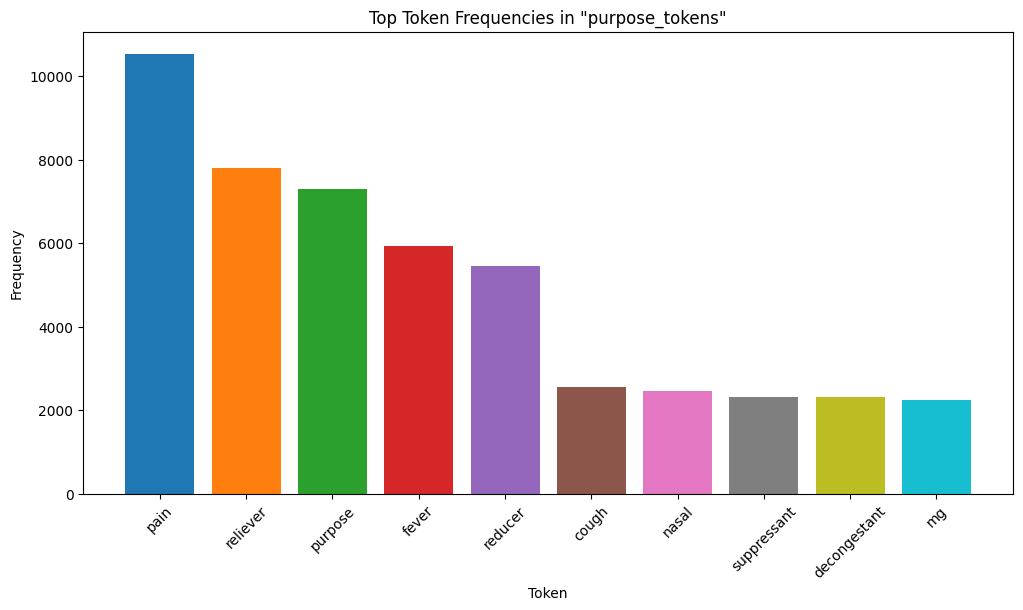

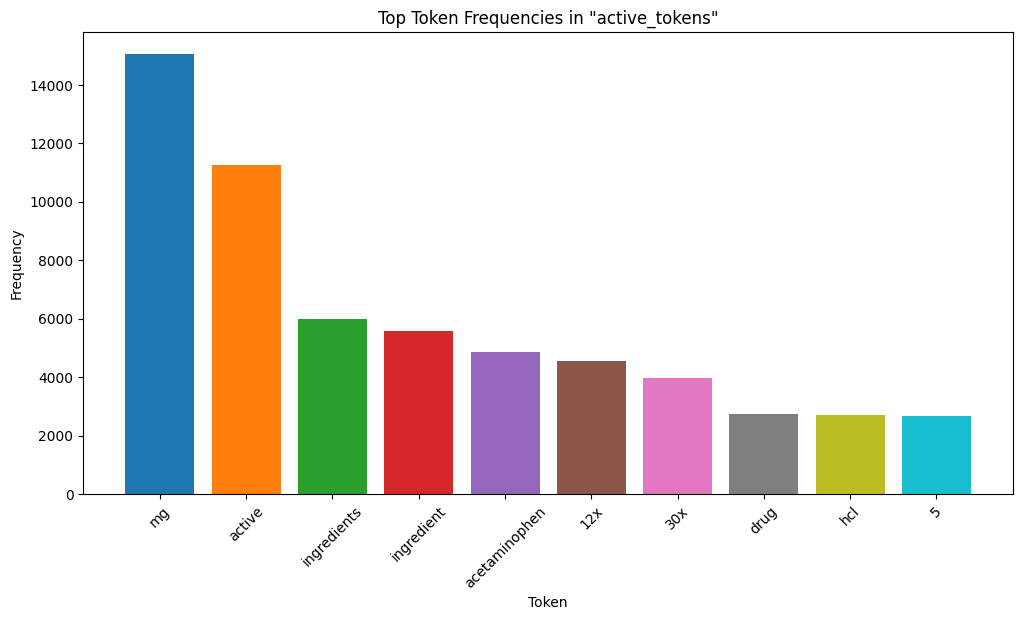

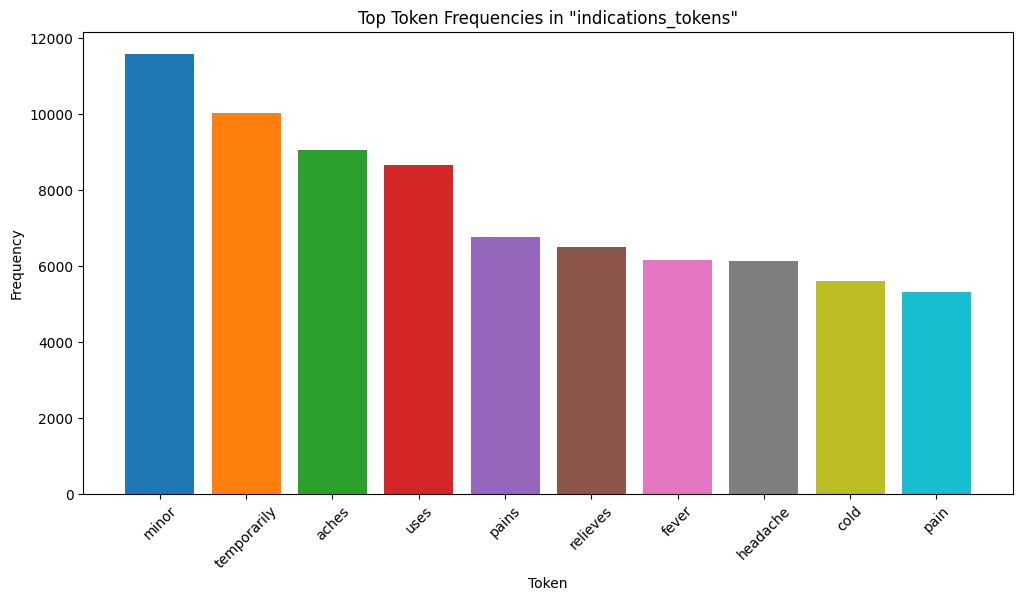

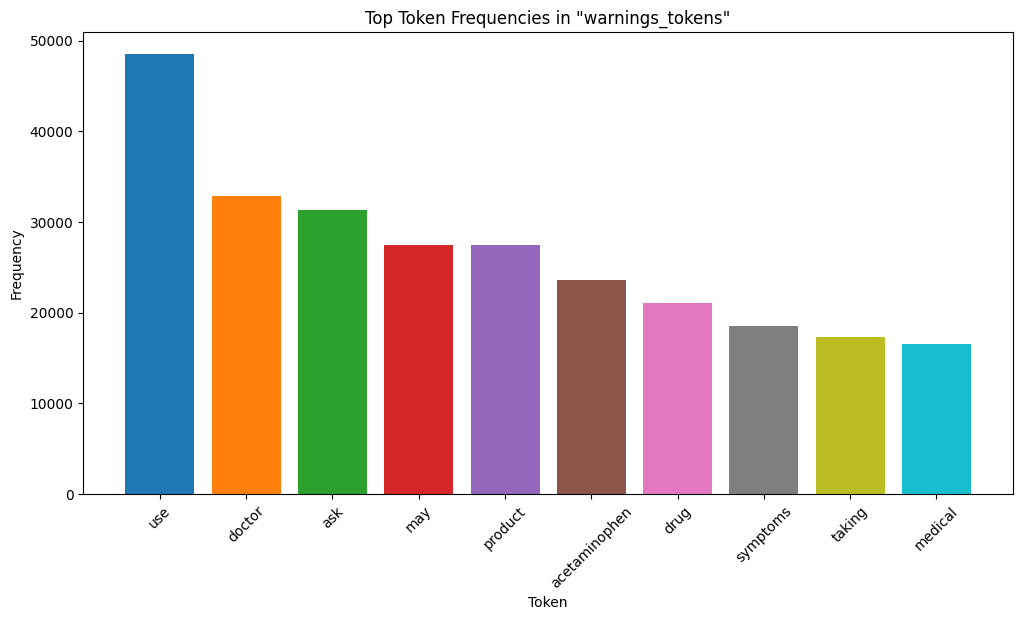

In [ ]:
# Create bar plots for each column
for column in token_categories:
    # Count the occurrences of each token in the column
    token_counts = clean_df[column].apply(lambda x: Counter(x))

    # Sum the token counts across all rows
    total_counts = token_counts.sum()

    # Get the top N tokens to display (adjust the number as needed)
    top_tokens = total_counts.most_common(10)

    # Create a bar plot for the token frequencies
    plt.figure(figsize = (12, 6))
    for i, (token, count) in enumerate(top_tokens):
        plt.bar(token, count, label = token)

    plt.title(f'Top 10 Tokens in "{column}"')
    plt.xlabel('Token')
    plt.ylabel('Count')
    plt.xticks(rotation = 45)
    plt.show()

### **Distribution: Amount of Tokens**

* Histogram

* Box Plot

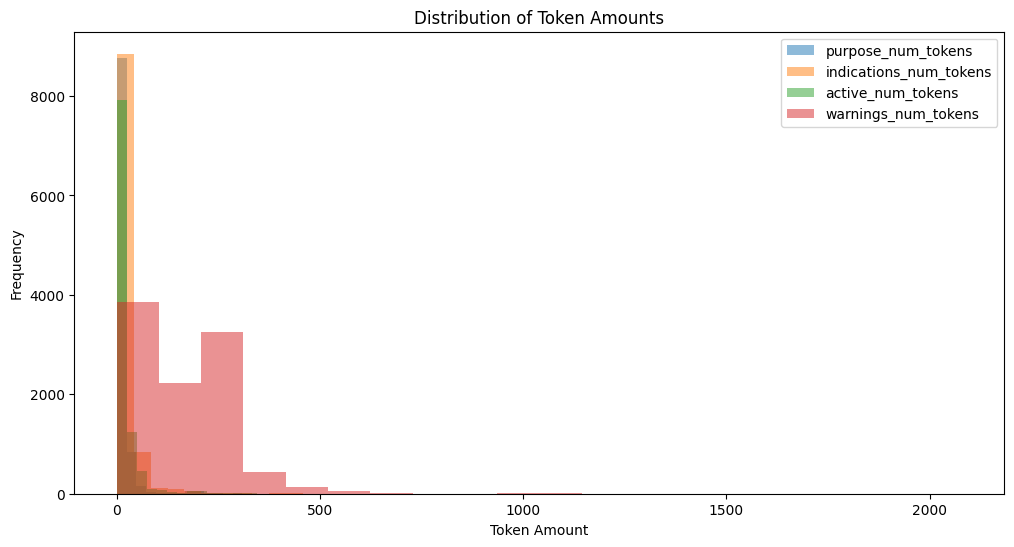

In [ ]:
# List of column names
num_token_columns = ['purpose_num_tokens', 'indications_num_tokens', 'active_num_tokens', 'warnings_num_tokens']

# Create histograms for the token amounts in each column
plt.figure(figsize = (12, 6))
for column in num_token_columns:
    plt.hist(clean_df[column], bins = 20, alpha = 0.5, label=column)

plt.title('Distribution of Token Amounts')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.legend()
plt.show()

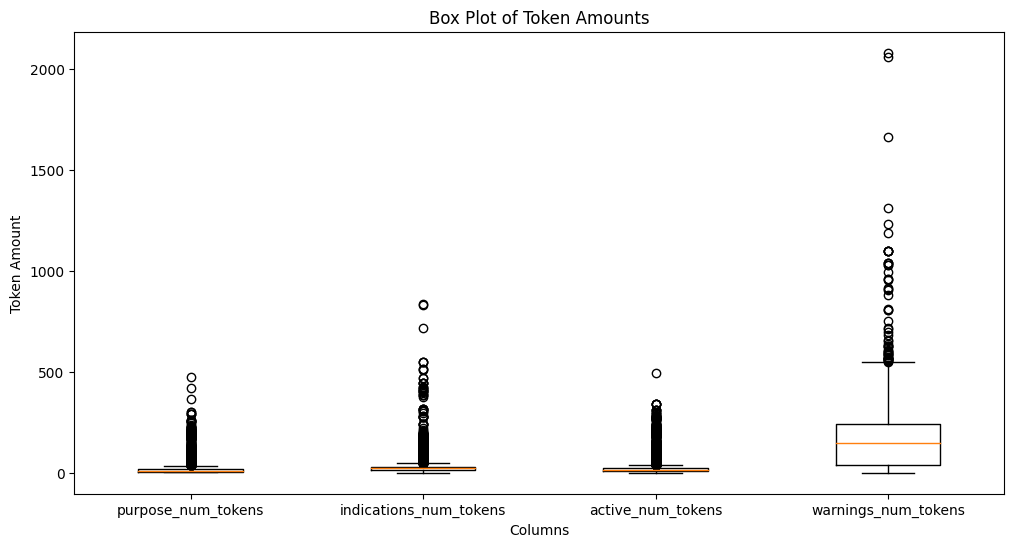

In [ ]:
# Create box plots for the token amounts in each column
plt.figure(figsize = (12, 6))
plt.boxplot([clean_df[column] for column in num_token_columns], labels = num_token_columns)
plt.title('Distribution of Token Amounts')
plt.xlabel('Columns')
plt.ylabel('Number of Tokens')
plt.show()

### **Word Cloud**

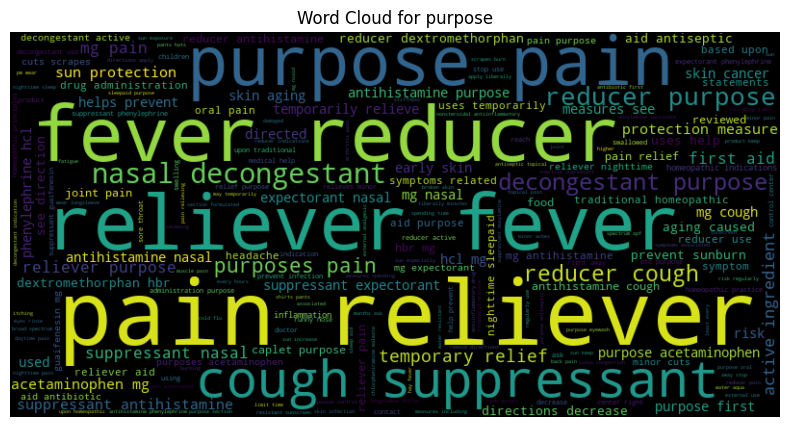

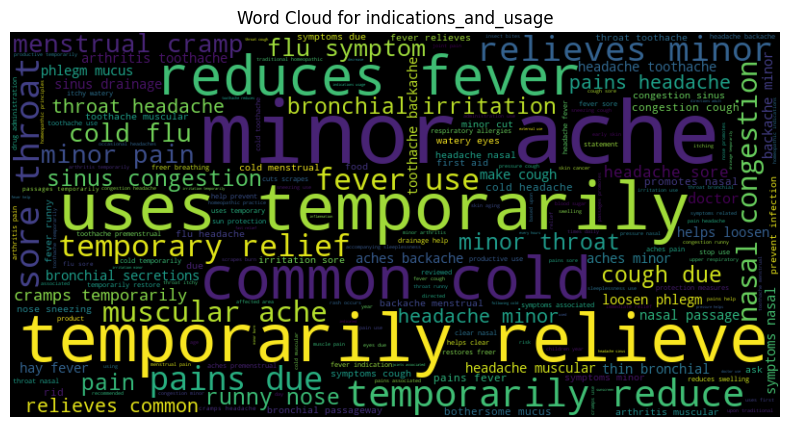

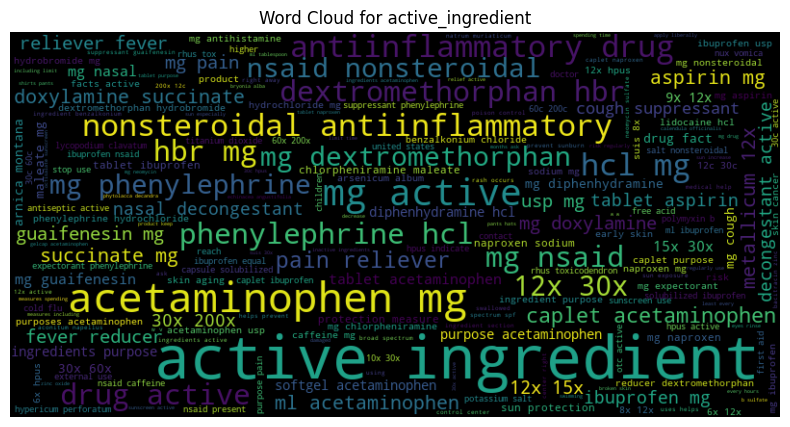

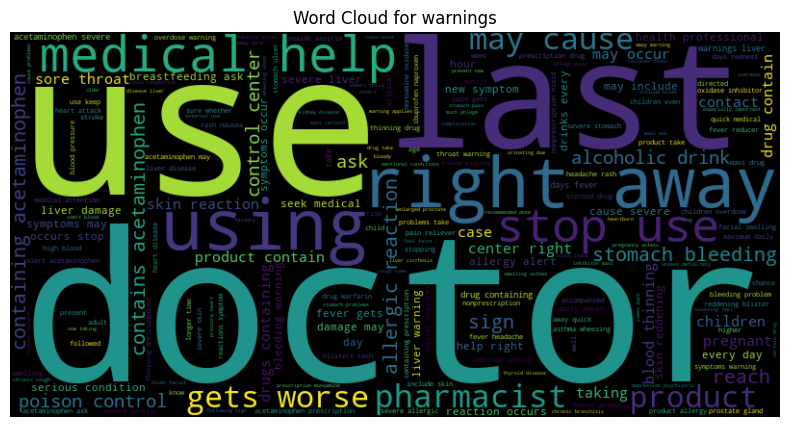

In [ ]:
# Define the text columns
text_columns = ['purpose', 'indications_and_usage', 'active_ingredient', 'warnings']

# Create a word cloud for each text column
for column in text_columns:
    # Combine the text data from the column into a single string
    text_data = ' '.join(clean_df[column].astype(str))

    # Create and generate a WordCloud object
    wordcloud = WordCloud(width = 800, height = 400).generate(text_data)

    # Display the word cloud
    plt.figure(figsize = (10, 5))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for {column}")
    plt.show()